# INFO 290 Final Project

<b>Team Members:</b> Erin Jones, Paul Kenniston, Shikha Shah

<b>Device:</b> Empatica EmbracePlus

<b>Presentation Date:</b> 11.7.2023

In [1]:
# Imports
import pandas as pd
import numpy as np
from avro.datafile import DataFileReader
from avro.io import DatumReader
import os
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
import neurokit2 as nk
import scipy.signal

In [2]:
df_11_9 = '/Users/erin/Documents/biosensory/eda_final/11.9.2023/raw_data/v6'
df_11_16 = '/Users/erin/Documents/biosensory/eda_final/11.16.2023/raw_data/v6'
df_11_21 = '/Users/erin/Documents/biosensory/eda_final/11.21.2023/raw_data/v6'

In [3]:
# Pre-processing functions

def pull_file(filepath:str):
    reader = DataFileReader(open(filepath, "rb"), DatumReader())
    data= next(reader)

    eda_raw_df = pd.DataFrame(data['rawData']['eda']) # timestampStart, samplingFrequency, values
    eda_raw_df['timestamp'] = add_timstamp(eda_raw_df)
    eda_raw_df.drop(columns=['timestampStart', 'samplingFrequency'], inplace=True)
    eda_raw_df.set_index('timestamp', inplace=True)


    temp_raw_df = pd.DataFrame(data['rawData']['temperature']) # timestampStart, samplingFrequency, values
    temp_raw_df['timestamp'] = add_timstamp(temp_raw_df)
    temp_raw_df.drop(columns=['timestampStart', 'samplingFrequency'], inplace=True)
    temp_raw_df.set_index('timestamp', inplace=True)

    bvp_raw_df = pd.DataFrame(data['rawData']['bvp']) # timestampStart, samplingFrequency, values
    bvp_raw_df['timestamp'] = add_timstamp(bvp_raw_df)
    bvp_raw_df.drop(columns=['timestampStart', 'samplingFrequency'], inplace=True)
    bvp_raw_df.set_index('timestamp', inplace=True)

    return eda_raw_df, temp_raw_df, bvp_raw_df

def add_timstamp(df:pd.DataFrame):
    timestamps = [round(df["timestampStart"][0] + i * (1e6 / df["samplingFrequency"]))
                for i in range(len(df["values"]))]
    
    times = []
    for i in range(0,len(timestamps)):
        time = (timestamps[i]).iloc[0]
        times.append(time)
    
    times_proper = (pd.to_datetime(times, unit='us', utc=True)).tz_convert('US/Pacific')

    times_final = []
    for time in times_proper:
        nt = time.strftime('%Y-%m-%d %H:%M:%S.%f000')
        t = pd.Timestamp(nt)
        times_final.append(t)

    return times_final

def clean_data(df: pd.DataFrame):

    df = df.sort_index(ascending=True)

    mean = np.mean(df['values'])
    std = np.std(df['values'])
    upper_fence = mean + std*2
    lower_fence = mean - std*2

    clean_df = (df[(df['values'] < upper_fence) & (df['values'] > lower_fence)]).copy()

    # normalize the values
    clean_df['n_values'] = ((clean_df['values'] - clean_df['values'].min()) / clean_df['values'].max() - clean_df['values'].min()) 

    # add rolling average for smoothing
    clean_df['roll'] = (clean_df['n_values']).rolling('10s').mean()

    return clean_df

def load_data(directory_path:str):

    file_names = [f"{directory_path}/{f}" for f in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, f))]

    eda_df_raw = pd.DataFrame()
    temp_df_raw = pd.DataFrame()
    bvp_df_raw = pd.DataFrame()

    for file_name in file_names:
        eda_raw_df, temp_raw_df, bvp_raw_df = pull_file(file_name)
        eda_df_raw = pd.concat([eda_df_raw, eda_raw_df])
        temp_df_raw = pd.concat([temp_df_raw, temp_raw_df])
        bvp_df_raw = pd.concat([bvp_df_raw, bvp_raw_df])
        
    eda_df = clean_data(eda_df_raw)
    bvp_df = clean_data(bvp_df_raw)
    temp_df = clean_data(temp_df_raw)

    return eda_df, temp_df, bvp_df

def trim_dataframe(df):
    """
    Removes the first and last 30 seconds of data from a dataframe with a timestamp index.

    Args:
    df (pd.DataFrame): A dataframe with a timestamp index.

    Returns:
    pd.DataFrame: A new dataframe with the first and last 30 seconds removed.
    """
    df = df.sort_index()
    
    start_time = df.index[0]
    end_time = df.index[-1]
    
    # calc new start and end times
    new_start_time = start_time + pd.Timedelta(seconds=30)
    new_end_time = end_time - pd.Timedelta(seconds=30)
    
    trimmed_df = df[(df.index >= new_start_time) & (df.index <= new_end_time)].copy()

    return trimmed_df

def split_dataframe(df):
    """
    Splits a dataframe with a timestamp index into three sections of 2 minutes and 30 seconds each.

    Args:
    df (pd.DataFrame): A dataframe with a timestamp index.

    Returns:
    tuple of pd.DataFrame: Three dataframes, each representing a 2 minutes and 30 seconds section.
    """
    df = df.sort_index()
    interval = pd.Timedelta(minutes=2, seconds=30)

    # split 3 sections
    start_time = df.index[0]
    end_time_1 = start_time + interval
    end_time_2 = end_time_1 + interval
    end_time_3 = end_time_2 + interval


    pd1 = df[(df.index >= start_time) & (df.index < end_time_1)].copy()
    pd2 = df[(df.index >= end_time_1) & (df.index < end_time_2)].copy()
    pd3 = df[(df.index >= end_time_2) & (df.index < end_time_3)].copy()

    return pd1, pd2, pd3

def split_into_segments(stim_number:int, df:pd.DataFrame):
    if stim_number == 1:
        order = ['ctrl', 'names', 'audio']
    elif stim_number == 2:
        order = ['ctrl', 'audio', 'names']
    elif stim_number == 3:
        order = ['names', 'ctrl', 'audio']
    elif stim_number == 4:
        order = ['names','audio', 'ctrl']
    elif stim_number == 5:
        order = ['audio', 'ctrl', 'names']
    elif stim_number == 6:
        order = ['audio', 'names','ctrl']
    else:
        print('Please enter a valid stimulus number')
    
    participant_dictionary = {}
    i = 0
    for stim in order:
        participant_dictionary[stim] = split_dataframe(df)[i]
        i+=1
    
    return participant_dictionary



In [5]:
directory_path = df_11_9

file_names = [f"{directory_path}/{f}" for f in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, f))]

eda_df_raw = pd.DataFrame()
temp_df_raw = pd.DataFrame()
bvp_df_raw = pd.DataFrame()

for file_name in file_names:
    eda_raw_df, temp_raw_df, bvp_raw_df = pull_file(file_name)
    eda_df_raw = pd.concat([eda_df_raw, eda_raw_df])
    temp_df_raw = pd.concat([temp_df_raw, temp_raw_df])
    bvp_df_raw = pd.concat([bvp_df_raw, bvp_raw_df])
    
eda_df = clean_data(eda_df_raw)
bvp_df = clean_data(bvp_df_raw)
temp_df = clean_data(temp_df_raw)

# return eda_df, temp_df, bvp_df

In [8]:
temp_df

,values,n_values,roll
timestamp,,,
2023-11-09 20:48:13.921837,29.851562,-29.843506,-29.843506
2023-11-09 20:48:14.922128,29.843750,-29.843750,-29.843628
2023-11-09 20:48:15.922418,29.843750,-29.843750,-29.843669
2023-11-09 20:48:16.922709,29.859375,-29.843263,-29.843567
2023-11-09 20:48:17.923000,29.843750,-29.843750,-29.843604
...,...,...,...
2023-11-10 12:24:43.016156,32.046875,-29.775020,-29.775264
2023-11-10 12:24:44.016403,32.039062,-29.775264,-29.775239
2023-11-10 12:24:45.016651,32.054688,-29.774776,-29.775166


# Pull Data + Parse

Unfortunately we would have needed to generate a unique QR code for each user to get distinct results, so I had to generate a formula that could be used to detect non-consecutive time series results.
* p1 = Emily - S2
* p2 = Billy - S4
* p3 = Ellis - S6
* p4 = Mustafa - S6
* p5 = Lingke - S5
* p6 = Neel - S2
* p7 = Winny - S3

In [9]:
# Billy + Emily Files

eda_df, temp_df, bvp_df = load_data(df_11_9)

p1_eda_dict = split_into_segments(2, (trim_dataframe((eda_df[eda_df.index < '2023-11-09 21:00:00']).copy())))
p1_temp_dict = split_into_segments(2, (trim_dataframe((temp_df[temp_df.index < '2023-11-09 21:00:00']).copy())))
p1_bvp_dict = split_into_segments(2, (trim_dataframe((bvp_df[bvp_df.index < '2023-11-09 21:00:00']).copy())))

p2_eda_dict = split_into_segments(4, (trim_dataframe((eda_df[eda_df.index > '2023-11-09 21:00:00']).copy())))
p2_temp_dict = split_into_segments(4, (trim_dataframe((temp_df[temp_df.index > '2023-11-09 21:00:00']).copy())))
p2_bvp_dict = split_into_segments(4, (trim_dataframe((bvp_df[bvp_df.index > '2023-11-09 21:00:00']).copy())))

# Ellis + Mustafa + Lingke Files

eda_df_2, temp_df_2, bvp_df_2 = load_data(df_11_16)

p3_eda_dict = split_into_segments(6, (trim_dataframe((eda_df_2[eda_df_2.index < '2023-11-16 16:22:00']).copy())))
p3_temp_dict = split_into_segments(6, (trim_dataframe((temp_df[temp_df.index < '2023-11-16 16:22:00']).copy())))
p3_bvp_dict = split_into_segments(6, ((trim_dataframe(bvp_df[bvp_df.index < '2023-11-16 16:22:00']).copy())))

p4_eda_dict = split_into_segments(6, (trim_dataframe((eda_df_2[(eda_df_2.index < '2023-11-16 16:38:00') & (eda_df_2.index > '2023-11-16 16:22:00')]).copy())))
p4_temp_dict = split_into_segments(6, (trim_dataframe((temp_df_2[(temp_df_2.index < '2023-11-16 16:38:00') & (temp_df_2.index > '2023-11-16 16:22:00')]).copy())))
p4_bvp_dict = split_into_segments(6, (trim_dataframe((bvp_df_2[(bvp_df_2.index < '2023-11-16 16:38:00') & (bvp_df_2.index > '2023-11-16 16:22:00')]).copy())))

p5_eda_dict = split_into_segments(5, (trim_dataframe((eda_df_2[eda_df_2.index > '2023-11-16 16:38:00']).copy())))
p5_temp_dict = split_into_segments(5, (trim_dataframe((temp_df_2[temp_df_2.index > '2023-11-16 16:38:00']).copy())))
p5_bvp_dict = split_into_segments(5, (trim_dataframe((bvp_df_2[bvp_df_2.index > '2023-11-16 16:38:00']).copy())))

# Neel + Winny Files

eda_df_3, temp_df_3, bvp_df_3 = load_data(df_11_21)

p6_eda_dict = split_into_segments(2, (trim_dataframe((eda_df_3[eda_df_3.index < '2023-11-21 13:40:00']).copy())))
p6_temp_dict = split_into_segments(2, (trim_dataframe((temp_df_3[temp_df_3.index < '2023-11-21 13:40:00']).copy())))
p6_bvp_dict = split_into_segments(2, (trim_dataframe((bvp_df_3[bvp_df_3.index < '2023-11-21 13:40:00']).copy())))

# this file is fat and we may want to ditch it...device was left on so time stamps are a bit hard to capture
# p7_eda = (eda_df[eda_df.index < '2023-11-21 13:40:00']).copy()
# p7_temp = (temp_df[temp_df.index < '2023-11-21 13:40:00']).copy()
# p7_bvp = (bvp_df[bvp_df.index < '2023-11-21 13:40:00']).copy()

In [10]:
all_eda_list = [p1_eda_dict, p2_eda_dict, p3_eda_dict, p4_eda_dict, p5_eda_dict, p6_eda_dict]
all_temp_list = [p1_temp_dict, p2_temp_dict, p3_temp_dict, p4_temp_dict, p5_temp_dict, p6_temp_dict]
all_bvp_list = [p1_bvp_dict, p2_bvp_dict, p3_bvp_dict, p4_bvp_dict, p5_bvp_dict, p6_bvp_dict]

In [11]:
def unshuffle(sensor_dfs_list):
    names = {}
    audio = {}
    ctrl = {}
    i = 1
    for participant in sensor_dfs_list:
        names[i] = participant['names']
        audio[i] = participant['audio']
        ctrl[i] = participant['ctrl']
        i+=1
    return names, audio, ctrl

In [12]:
eda_names, eda_audio, eda_ctrl = unshuffle(all_eda_list)
temp_names, temp_audio, temp_ctrl = unshuffle(all_temp_list)
bvp_names, bvp_audio, bvp_ctrl = unshuffle(all_bvp_list)

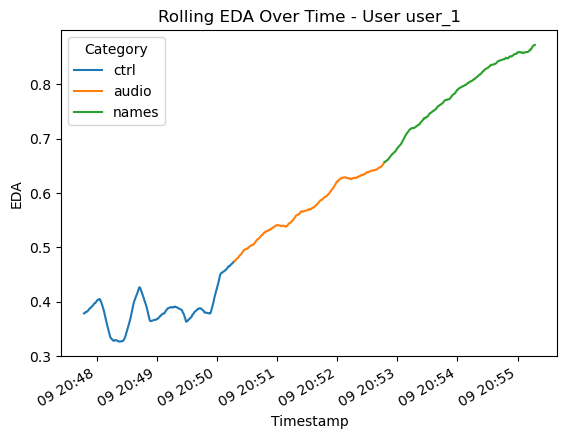

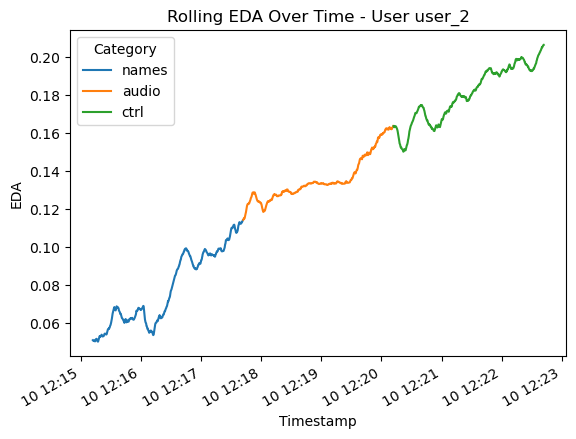

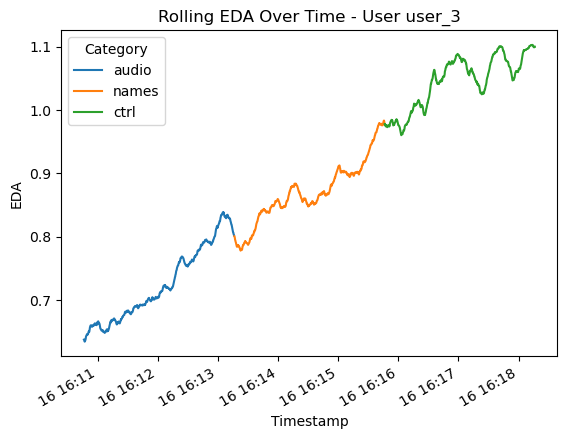

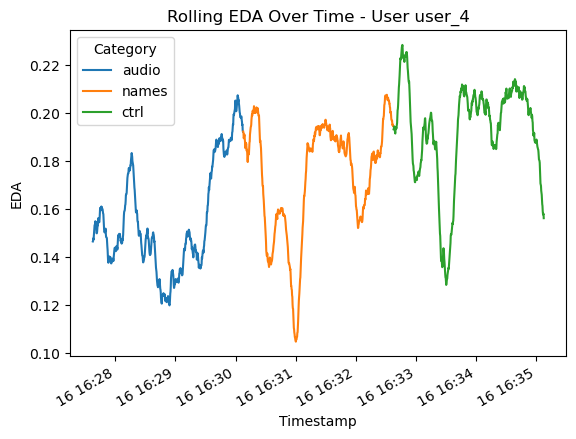

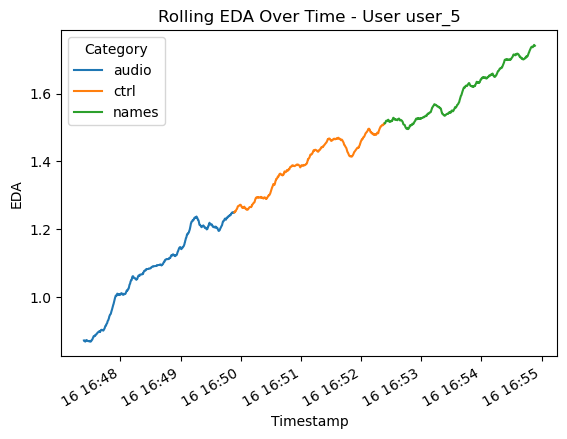

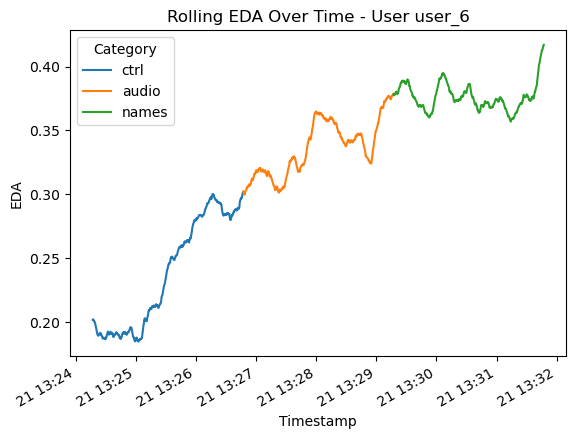

In [26]:
def pull_plot_single_ts(eda_dict, user_id):
    fig, ax = plt.subplots()
    for stim, df in eda_dict.items():
        df['roll'].plot(ax=ax, label=stim)

    # Setting legend, title, and labels
    ax.legend(title='Category')
    ax.set_title(f'Rolling EDA Over Time - User {user_id}')
    ax.set_xlabel('Timestamp')
    ax.set_ylabel('EDA')
    return plt.show()


pull_plot_single_ts(p1_eda_dict, 'user_1')
pull_plot_single_ts(p2_eda_dict, 'user_2')
pull_plot_single_ts(p3_eda_dict, 'user_3')
pull_plot_single_ts(p4_eda_dict, 'user_4')
pull_plot_single_ts(p5_eda_dict, 'user_5')
pull_plot_single_ts(p6_eda_dict, 'user_6')



## Plotting the stim for each trial

'n_values', 'values', 'roll'

In [13]:
def plot_stim(eda_dict, temp_dict, bvp_dict, block_name):
    fig, axes = plt.subplots(len(eda_dict), 1, figsize=(10, 9))
    for i in range(0,len(eda_dict)):
        eda = eda_dict[i+1]
        # temp = temp_dict[i+1]
        # bvp = bvp_dict[i+1]
        # Create and customize each line plot
        sns.lineplot(x=eda.index, y=eda['roll'], ax=axes[i], color='#95c2a4')
        axes[i].set_title(f'Participant {i} EDA v. Time - {block_name}')
        axes[i].set_ylabel(f'Norm Rolling EDA')
        axes[i].set_xlabel(f'Time')
        # sns.lineplot(x=temp.index, y=temp['roll'], ax=axes[i, 1])
        # axes[i, 1].set_title(f'Participant {i} Temp v. Time - {block_name}')
        # sns.lineplot(x=bvp.index, y=bvp['roll'], ax=axes[i, 2])
        # axes[i, 2].set_title(f'Participant {i} BVP v. Time - {block_name}')
    plt.tight_layout()
    return plt.show()

### Time Series Plots for Control Stimulus

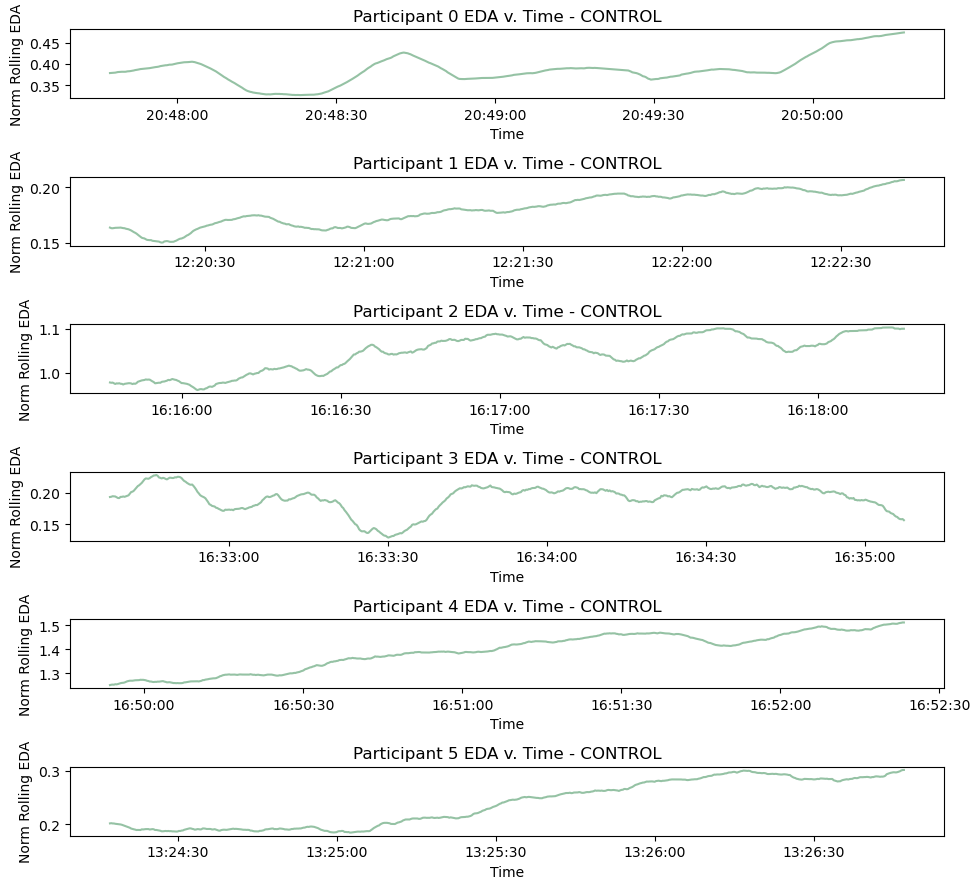

In [14]:
plot_stim(eda_ctrl, temp_ctrl, bvp_ctrl, 'CONTROL')

### Time Series Plots for Named Images --- Moniker

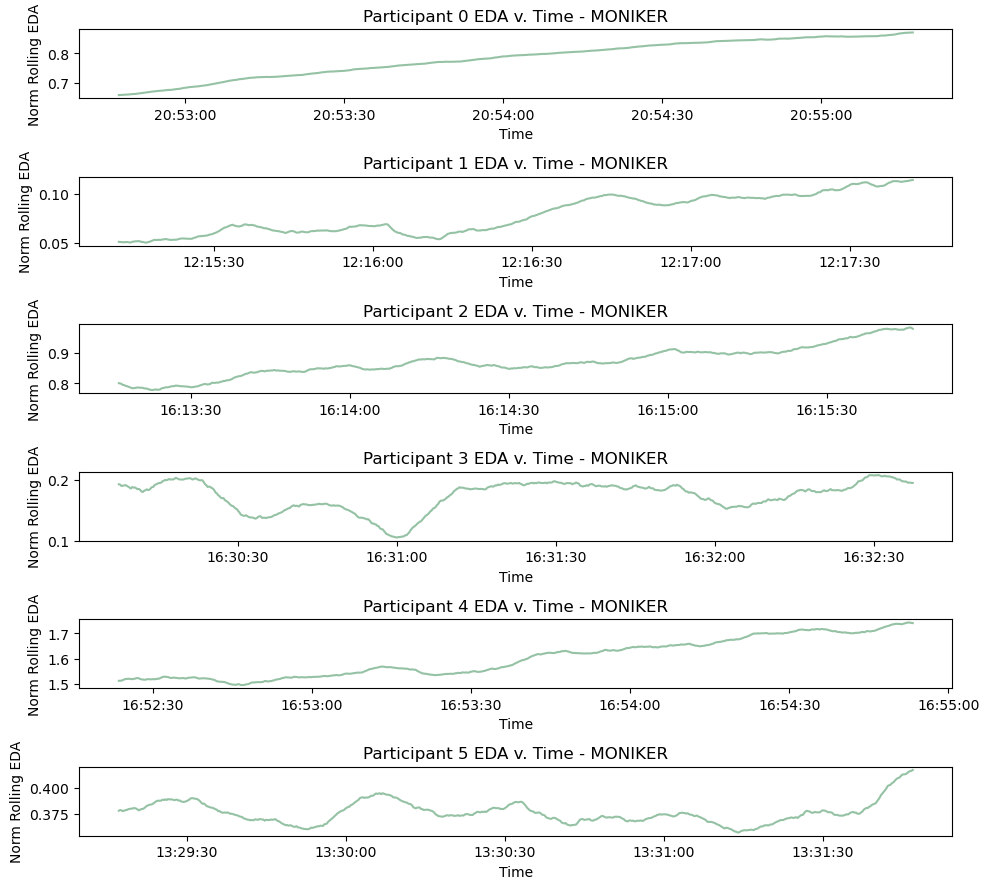

In [15]:
plot_stim(eda_names, temp_names, bvp_names, 'MONIKER')

### Time Series Plots for Backstory

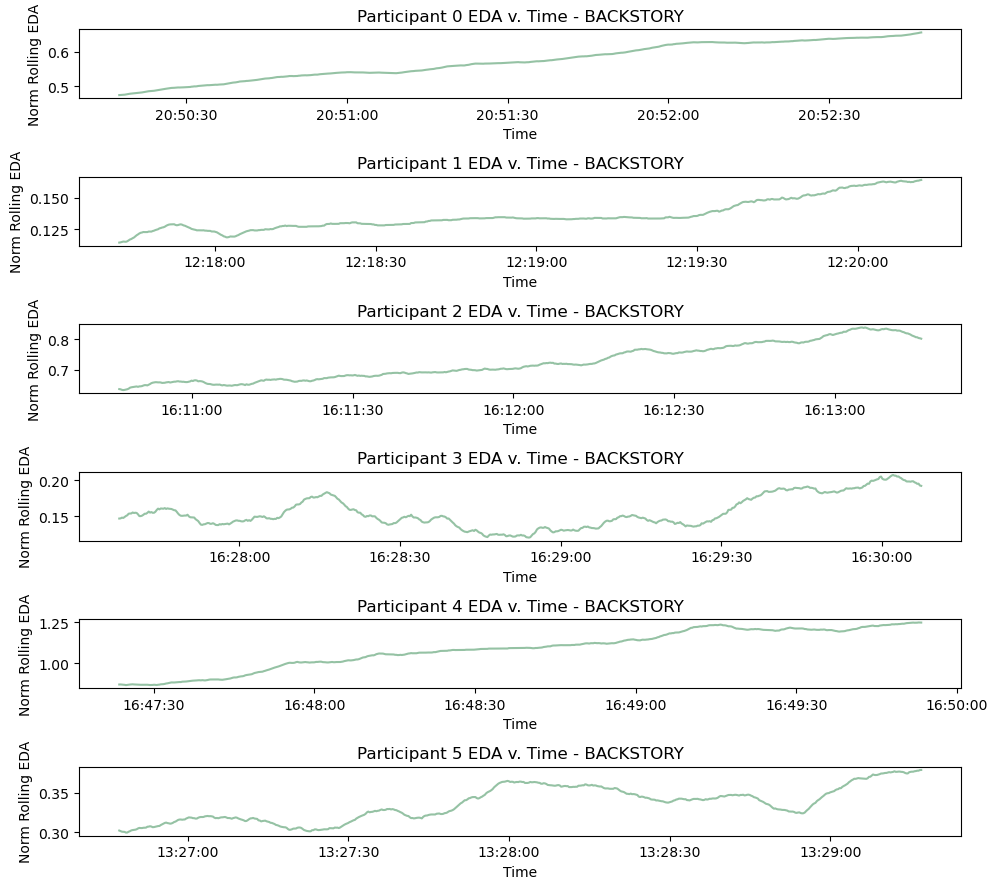

In [16]:
plot_stim(eda_audio, temp_audio, bvp_audio, 'BACKSTORY')

In [40]:
def pull_plot_stats(eda_dict, bvp_dict, block_name):
    
    numpy_array = np.empty((len(eda_dict), 2))

    for i in range(0, len(eda_dict)):
        participant_row = []
        eda = eda_dict[i+1]
        # bvp = bvp_dict[i+1]
        participant_row.append(eda['n_values'].mean())
        participant_row.append(eda['n_values'].median())
        # participant_row.append(bvp['n_values'].mean())
        # participant_row.append(bvp['n_values'].median())
        numpy_array[i,:] = np.array(participant_row)

    df = pd.DataFrame(numpy_array, columns = ['eda_mean', 'eda_med'])
    # df = pd.DataFrame(numpy_array, columns = ['eda_mean', 'eda_med', 'bvp_mean', 'bvp_med'])

    # Melting the DataFrame
    melted_df = df.reset_index().melt(id_vars='index', value_vars=df.columns)
    melted_df.rename(columns={'index': 'Participant', 'variable': 'Metric', 'value': 'Normalized EDA'}, inplace=True)

    colors = ['#ebac66', '#be5552', '#a7cdb4', '#e09a4a', '#fbedaf', '#d16561']

    # Creating the bar plot
    sns.barplot(x='Metric', y='Normalized EDA', hue='Participant', data=melted_df, palette=colors)
    plt.title(f'{block_name} Summary Stats')

    return plt.show()

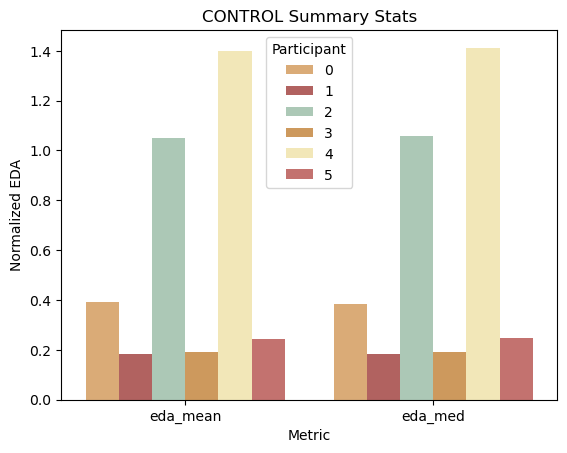

In [41]:
pull_plot_stats(eda_ctrl, bvp_ctrl, 'CONTROL')

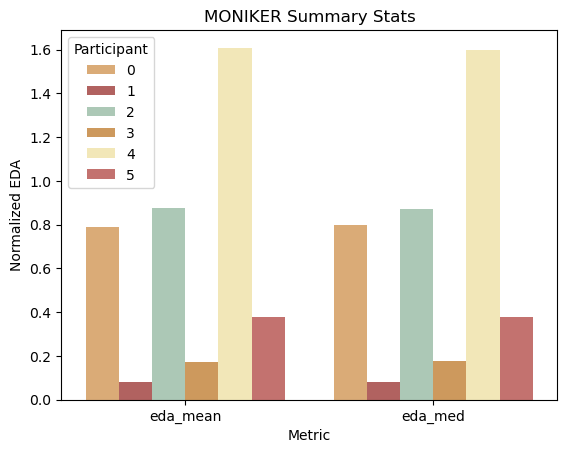

In [42]:
pull_plot_stats(eda_names, bvp_names, 'MONIKER')

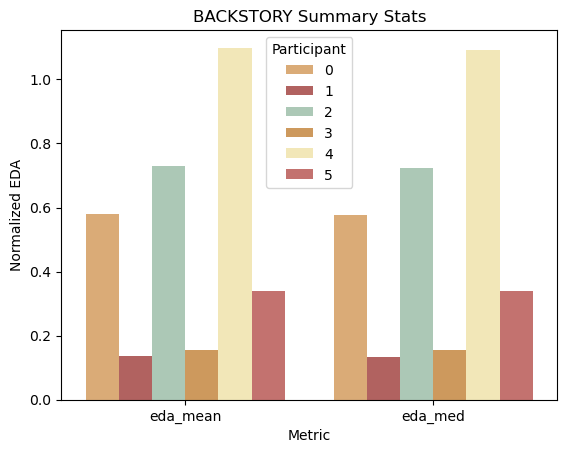

In [43]:
pull_plot_stats(eda_audio, bvp_audio, 'BACKSTORY')

## Phasic + Tonic Extraction -- Success

Thanks to John's code and Filipe's resampling code from using the E4!

In [44]:
# Thanks Filipe Santos for the basis on the code below for resample
def resample_and_decompose(df_dict, block_name):
    fig,axs = plt.subplots(6, 2, sharex=True, figsize=(20, 10))
    fig.suptitle(f'{block_name} EDA Decomposition', fontsize=16)
    i = 0
    
    for participant, df in df_dict.items():
        cleaned_eda_df = df.reset_index(drop=True)

        current_sampling_rate = 4.001697063446045
        new_sampling_rate = 100

        # Resample 
        resampled_eda = nk.signal_resample(cleaned_eda_df['values'], sampling_rate=current_sampling_rate, desired_sampling_rate=new_sampling_rate)

        # Create a new DataFrame with the resampled EDA data
        resampled_eda_df = pd.DataFrame({'EDA': resampled_eda})
        # display(resampled_eda_df)

        signals, info = nk.eda_process(resampled_eda_df['EDA'], sampling_rate=new_sampling_rate)
        cleaned = signals["EDA_Clean"]
        features = [info["SCR_Onsets"], info["SCR_Peaks"], info["SCR_Recovery"]]

        # # Visualize SCR features in cleaned EDA signal
        # plot = nk.events_plot(features, cleaned, color=['red', 'blue', 'orange'])
        hpf = scipy.signal.butter(5, 0.05, btype="highpass", output="sos", fs=new_sampling_rate) # 5th order filter, cutoff freq 0.05Hz
        lpf = scipy.signal.butter(5, 0.05, btype="lowpass", output="sos", fs=new_sampling_rate)

        eda_phasic = scipy.signal.sosfiltfilt(hpf, resampled_eda_df['EDA'])
        eda_tonic = scipy.signal.sosfiltfilt(lpf, resampled_eda_df['EDA'])
        axs[i, 0].plot(eda_phasic, label="Skin Conductance Response", color='#95c2a4')
        axs[i, 0].set_title('Phasic')
        axs[i, 1].plot(eda_tonic, label="Skin Conductance Level", color='#d16561')
        axs[i, 1].set_title('Tonic')
        i+=1
        
    plt.tight_layout()
    return plt.show()

In [45]:
eda_trials = [eda_ctrl, eda_names, eda_audio]
order = ['ctrl', 'names', 'audio']

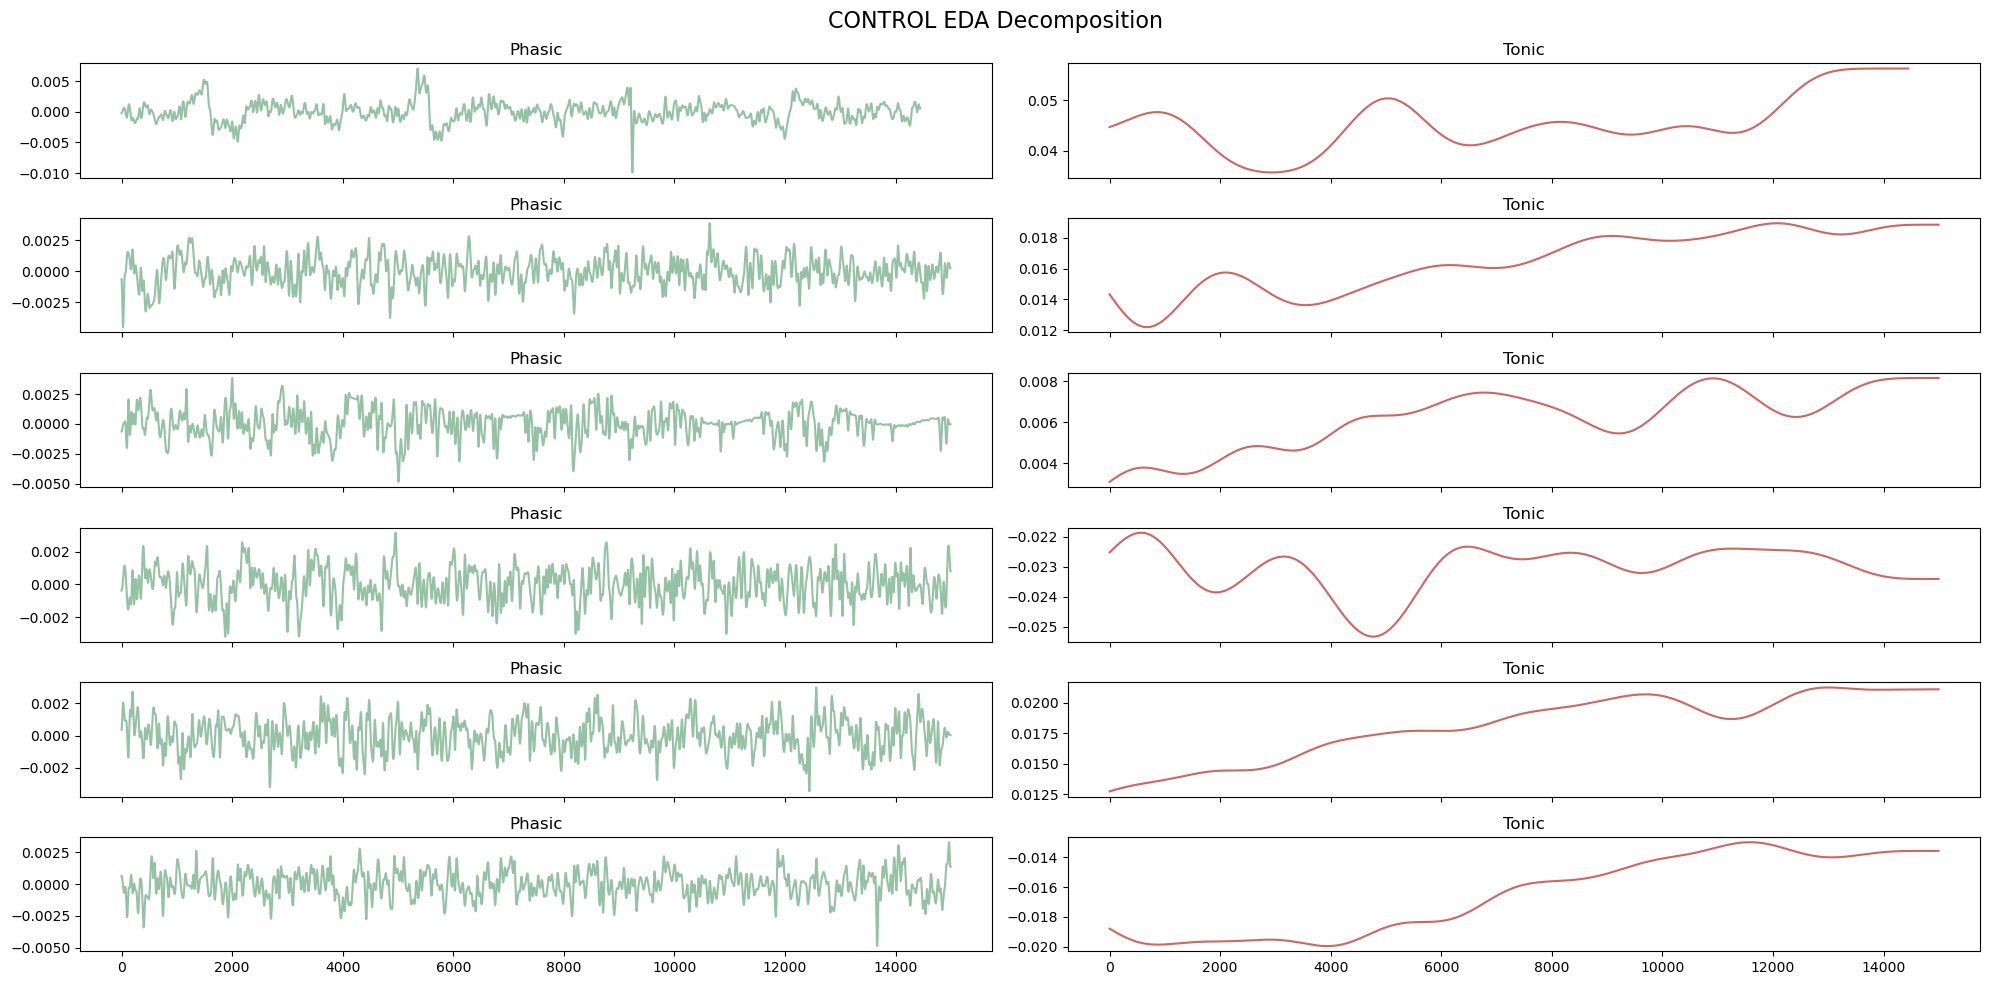

In [46]:
resample_and_decompose(eda_ctrl, 'CONTROL')

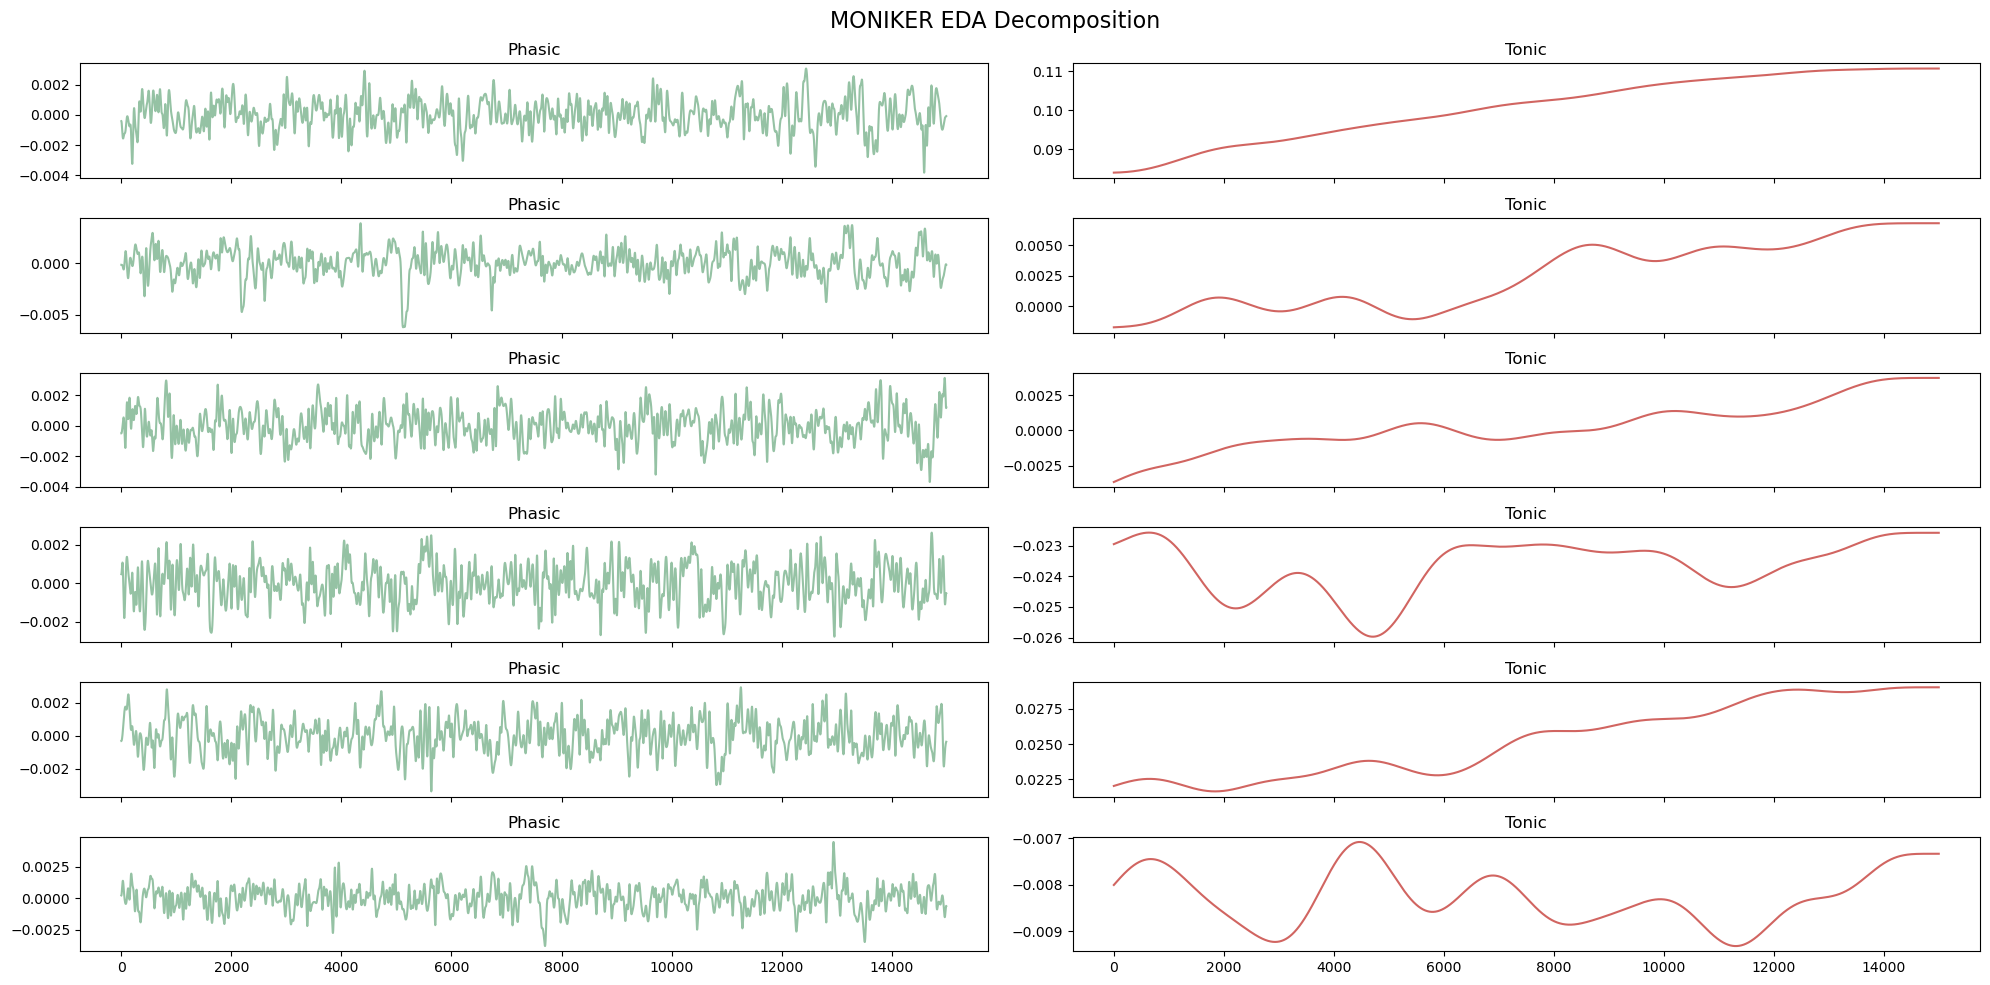

In [47]:
resample_and_decompose(eda_names, 'MONIKER')

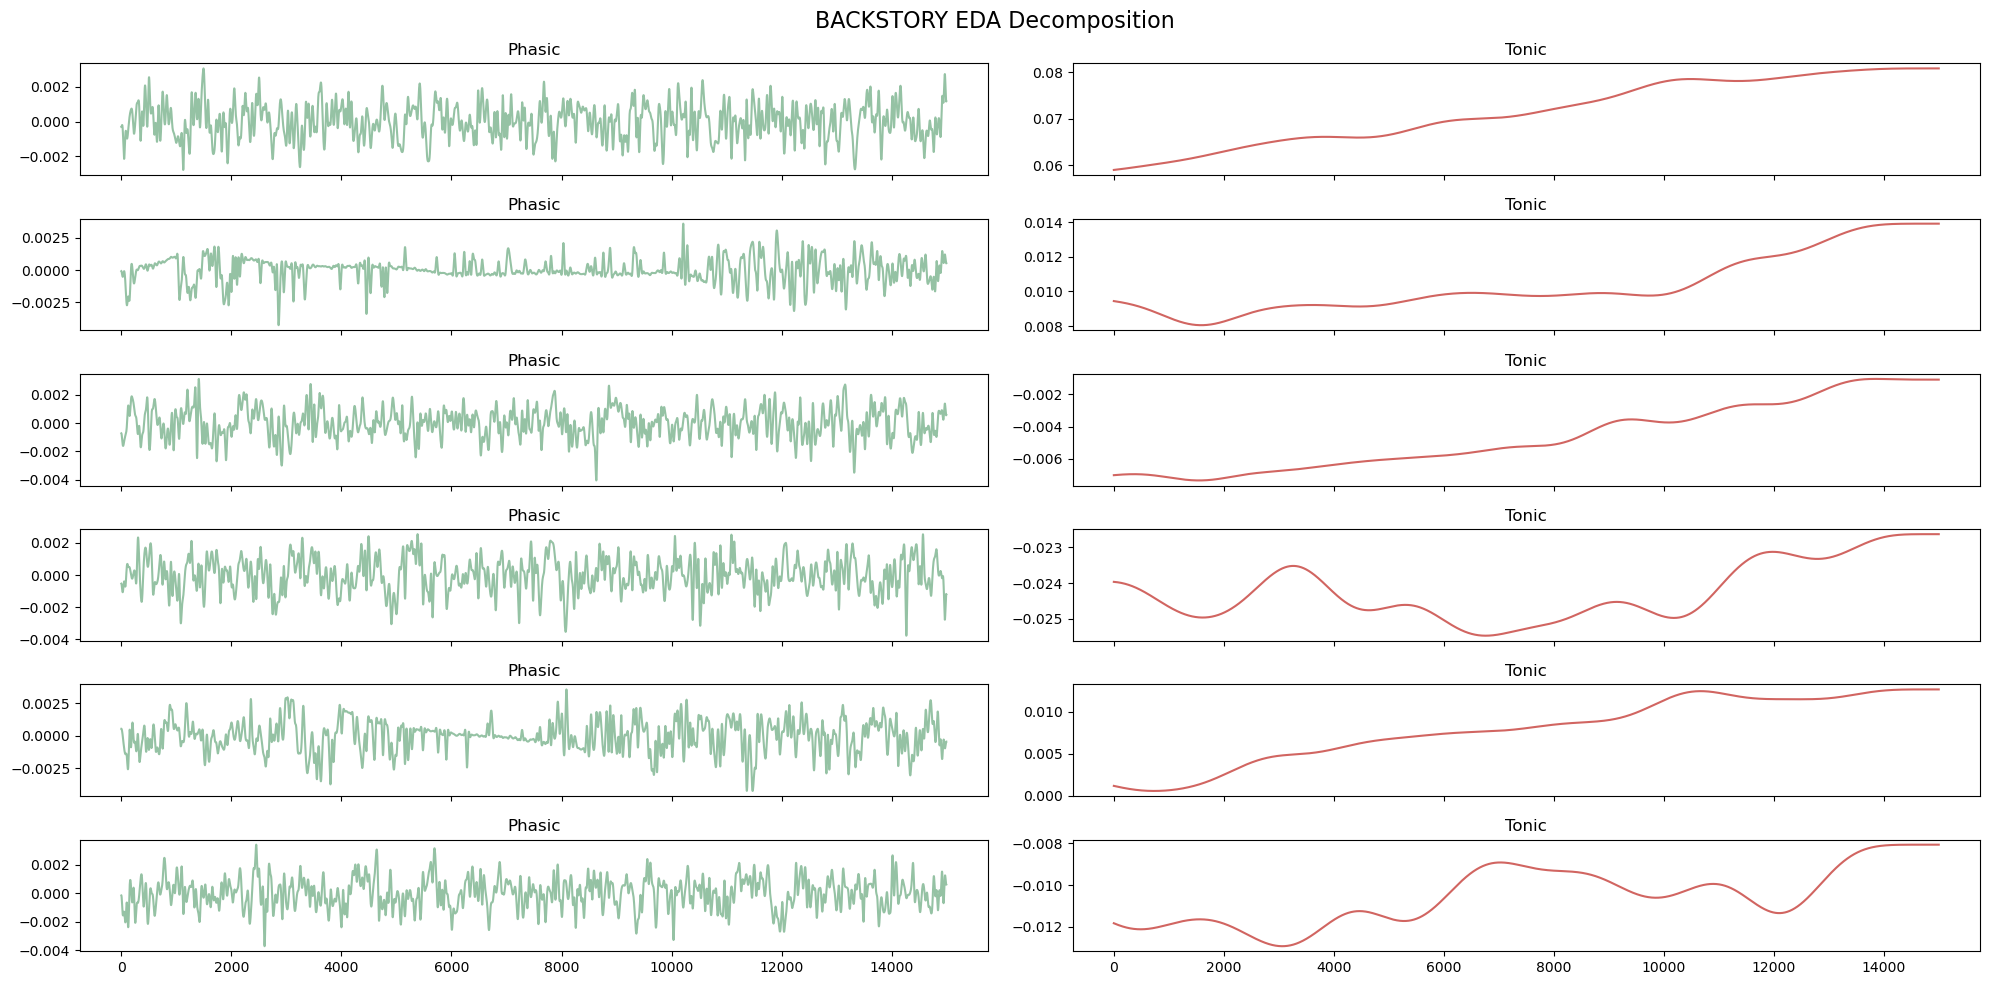

In [48]:
resample_and_decompose(eda_audio, 'BACKSTORY')